<a href="https://colab.research.google.com/github/dominiksakic/generative_ai/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

575046/575046 ━━━━━━━━━━━━━━━━━━━━ 3s 4us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [3]:
import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(
  image_path, target_size=(img_height, img_width))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img_height, img_width, 3))
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [4]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
import tensorflow as tf

def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(combination_img - base_img))

In [6]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style_img, combination_img):
  S = gram_matrix(style_img)
  C = gram_matrix(combination_img)
  channels = 3
  size = img_height * img_width
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [7]:
def total_variation_loss(x):
  a = tf.square(
      x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
  b = tf.square(
    x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
style_layer_names = [
  "block1_conv1",
  "block2_conv1",
  "block3_conv1",
  "block4_conv1",
  "block5_conv1",
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat(
      [base_image, style_reference_image, combination_image], axis=0)
  features = feature_extractor(input_tensor)
  loss = tf.zeros(shape=())
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(
      base_image_features, combination_features)

  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss_value = style_loss(
        style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * style_loss_value
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(
    combination_image,
    base_image,
    style_reference_image):

  with tf.GradientTape() as tape:
    loss = compute_loss(
        combination_image,
        base_image,
        style_reference_image)
    grads = tape.gradient(loss, combination_image)
  return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        )
)

In [10]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(
      combination_image,
      base_image,
      style_reference_image)

  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print(f"Iteration {i}: loss={loss:.2f}")
    img = deprocess_image(combination_image.numpy())
    fname = f"combination_image_at_iteration_{i}.png"
    keras.utils.save_img(fname, img)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 400, 533, 3))
  warnings.warn(msg)


Iteration 100: loss=1238.88
Iteration 200: loss=660.67
Iteration 300: loss=461.95
Iteration 400: loss=366.36
Iteration 500: loss=310.77
Iteration 600: loss=274.45
Iteration 700: loss=248.84
Iteration 800: loss=229.77
Iteration 900: loss=214.99
Iteration 1000: loss=203.20
Iteration 1100: loss=193.56
Iteration 1200: loss=185.53
Iteration 1300: loss=178.73
Iteration 1400: loss=172.91
Iteration 1500: loss=167.86
Iteration 1600: loss=163.45
Iteration 1700: loss=159.56
Iteration 1800: loss=156.10
Iteration 1900: loss=153.02
Iteration 2000: loss=150.25
Iteration 2100: loss=147.75
Iteration 2200: loss=145.48
Iteration 2300: loss=143.41
Iteration 2400: loss=141.53
Iteration 2500: loss=139.80
Iteration 2600: loss=138.21
Iteration 2700: loss=136.75
Iteration 2800: loss=135.40
Iteration 2900: loss=134.14
Iteration 3000: loss=132.98
Iteration 3100: loss=131.91
Iteration 3200: loss=130.90
Iteration 3300: loss=129.96
Iteration 3400: loss=129.09
Iteration 3500: loss=128.27
Iteration 3600: loss=127.50


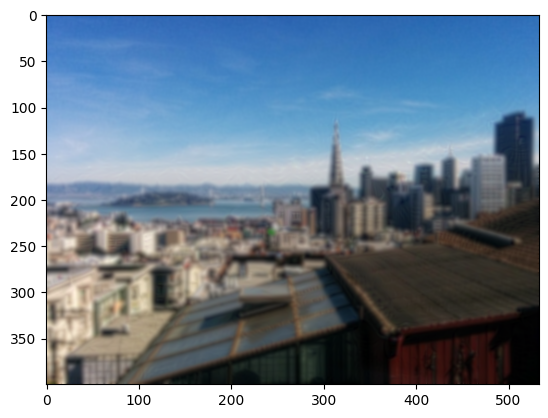

In [14]:
import matplotlib.pyplot as plt

img_to_display = keras.utils.load_img('combination_image_at_iteration_4000.png')
plt.imshow(img_to_display)
plt.show()